In [1]:
import os
import pandas as pd
import numpy as np 
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer    
from nltk.stem import WordNetLemmatizer
sns.set()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def getData(path):
    dataList = list()
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print(os.path.join(subdir, file))
            f = open(subdir+"/"+file, "r")
            dataList.append(f.read())
    return dataList
            
def avgWordCount(wordList):
    wordCount = 0
    for wordArray in wordList:
        wordCount += len(wordArray)
    wordAverage = wordCount/len(wordList)
    return wordAverage          


def preprocess(dataList, allPreprocessing = False):
    # https://textblob.readthedocs.io/en/dev/
    wordList = list()
    wordListStem = list()
    wordListLemmatized = list()
    
    # stemming / lemmatization
    # https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')

    stops = set(stopwords.words("english"))
    for text in dataList:
            # lowercase
            textLowercase = text.lower()
            # remove digits (not sure if we should do this, ad does is in the slides)
            textFiltered = re.sub(r'\b[0-9]+\b\s*', '', textLowercase)
            #print(text)
            # get textblob
            blob = TextBlob(textFiltered)
            # tokenize
            words = blob.words
            #print(words)
            if (allPreprocessing):
                # remove stopwords and stem
                wordsFiltered_stem = [stemmer.stem(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered_lemmatized = [wordnet_lemmatizer.lemmatize(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                #print(wordsFiltered)
                wordList.append(wordsFiltered)
                wordListStem.append(wordsFiltered_stem)
                wordListLemmatized.append(wordsFiltered_lemmatized)
            else:
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                wordList.append(wordsFiltered)
                
    if (allPreprocessing):            
        return (wordList, wordListStem, wordListLemmatized)
    else:
        return wordList

"""
https://www.mygreatlearning.com/blog/bag-of-words/#ed4
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
Calculate bag of words representation 
datasets: array with test data in first slot and training data in second slot
ngram: corresponding ngram: (1,1) for unigrams, (2,2) for bigrams
classDist = class distribution of the datasets. default assumes no prior changes to the data structure
return: each return consists of 2 dataframes: first dataframe is test data, second data is train data. 
        bag_of_words_data holds features with absolute count; bag_of_words_data_freq has word frequencies
"""
def bagOfWords(datasets, ngram, classDist = [np.repeat([0,1], 80),np.repeat([0,1], 320)]):
    # hyperparameters: max features, use_idf                                             
    vectorizer = CountVectorizer(ngram_range=ngram)#, max_features=750)
    bag_of_words_data_freq = list()
    bag_of_words_data = list()                                         
    tf_transformer = TfidfTransformer()#use_idf=True)
    for idx, dataset in enumerate(datasets):
        # reconcatenate data to sentence which is needed for countvectorizer
        concatTexts = list()
        for text in dataset:
            concatTexts.append(' '.join(text))
        # create bag of words representation
        if(idx == 0):
            countData = vectorizer.fit_transform(concatTexts)
        else:
            countData = vectorizer.transform(concatTexts)

        cv_df=pd.DataFrame(countData.toarray(),columns=vectorizer.get_feature_names())
        cv_df['class_target']=classDist[idx]
        bag_of_words_data.append(cv_df)

        freqData = tf_transformer.fit_transform(countData)
        cv_df_freq=pd.DataFrame(freqData.toarray(),columns=vectorizer.get_feature_names())
        cv_df_freq['class_target']=classDist[idx]
        bag_of_words_data_freq.append(cv_df_freq)
    return (bag_of_words_data, bag_of_words_data_freq, vectorizer)


"""
Calculate metrics for a model and plot the confusion matrix
actual: array with actual classes
pred: array with predicted classes
return: confusion matrix and a tuple with 3 values of accuracy, precision and recall
"""
def getModelInfo(actual, pred):
    df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    acc = (df_confusion[1][1] + df_confusion[0][0]) / (df_confusion[0]["All"] + df_confusion[1]["All"])
    prec = (df_confusion[1][1] / df_confusion[1]["All"])
    recall = (df_confusion[1][1] / df_confusion["All"][1])
    f1 =  2*((prec*recall)/(prec+recall))
    metrics = (acc, prec, recall, f1)
    plot_confusion_matrix(df_confusion)
    print("Metrics: \n   Accuracy: %f \n   Precision: %f \n   Recall: %f \n   F1: %f" % metrics)
    return df_confusion, metrics
"""
Plot the confusion matrix as a heatmap
df_confusion: confusion matrix from a model
return: nothing
"""
def plot_confusion_matrix(df_confusion):
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    return



In [7]:
deceptive_test = getData(r"data\deceptive\test")
deceptive_train = getData(r"data\deceptive\train")
truthful_test = getData(r"data\truthful\test")
truthful_train = getData(r"data\truthful\train")

In [28]:
#deceptive_test

In [17]:
post_deceptive_test, post_deceptive_test_stem, post_deceptive_test_lemmatized = preprocess(deceptive_test, allPreprocessing = True)
post_deceptive_train, post_deceptive_train_stem, post_deceptive_train_lemmatized = preprocess(deceptive_train, allPreprocessing = True)
post_truthful_test, post_truthful_test_stem, post_truthful_test_lemmatized = preprocess(truthful_test, allPreprocessing = True)
post_truthful_train, post_truthful_train_stem, post_truthful_train_lemmatized = preprocess(truthful_train, allPreprocessing = True)

In [9]:
# post_deceptive_test = preprocess(deceptive_test)
# post_deceptive_train = preprocess(deceptive_train)
# post_truthful_test = preprocess(truthful_test)
# post_truthful_train = preprocess(truthful_train)

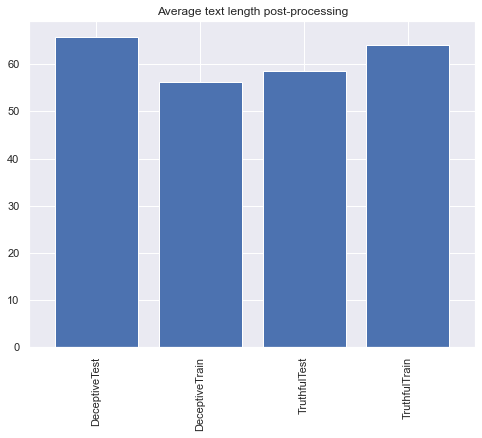

In [12]:
postAvgWordDeceptiveTest = avgWordCount(post_deceptive_test)
postAvgWordDeceptiveTrain = avgWordCount(post_deceptive_train)
postAvgWordTtruthfulTest = avgWordCount(post_truthful_test)
postAvgWordTruthfulTrain = avgWordCount(post_truthful_train)


metrics_df = pd.DataFrame([postAvgWordDeceptiveTest, postAvgWordDeceptiveTrain, postAvgWordTtruthfulTest, postAvgWordTruthfulTrain], columns=["Post-processing"], index=["DeceptiveTest", "DeceptiveTrain", "TruthfulTest", "TruthfulTrain"])
metrics_df.plot(kind='bar', legend=False, width=0.8, figsize=(8,6))
plt.title("Average text length post-processing")
plt.show()

In [18]:
# bag of words dataset creation
# create array with test and train data
datasets = [post_deceptive_test + post_truthful_test, post_deceptive_train + post_truthful_train]
datasets_stem = [post_deceptive_test_stem + post_truthful_test_stem, post_deceptive_train_stem + post_truthful_train_stem]
datasets_lemmatized = [post_deceptive_test_lemmatized + post_truthful_test_lemmatized, post_deceptive_train_lemmatized + post_truthful_train_lemmatized]

bag_of_words_data, bag_of_words_data_freq, vectorizer = bagOfWords(datasets = datasets, ngram = (1,1))
bag_of_words_data_stem, bag_of_words_data_freq_stem, a = bagOfWords(datasets = datasets_stem, ngram = (1,1))
bag_of_words_data_lemmatized, bag_of_words_data_freq_lemmatized, a = bagOfWords(datasets = datasets_lemmatized, ngram = (1,1))

    
bag_of_words_test = bag_of_words_data[0]
bag_of_words_train = bag_of_words_data[1]
bag_of_words_test_stem = bag_of_words_data_stem[0]
bag_of_words_train_stem = bag_of_words_data_stem[1]
bag_of_words_test_lemmatized = bag_of_words_data_lemmatized[0]
bag_of_words_train_lemmatized = bag_of_words_data_lemmatized[1]

y_test = np.array(bag_of_words_test[['class_target']].values.ravel())
X_test = bag_of_words_test.drop('class_target', axis=1)
y_train = np.array(bag_of_words_train[['class_target']].values.ravel())
X_train = bag_of_words_train.drop('class_target', axis=1)

y_test_stem = np.array(bag_of_words_test_stem[['class_target']].values.ravel())
X_test_stem = bag_of_words_test_stem.drop('class_target', axis=1)
y_train_stem = np.array(bag_of_words_train_stem[['class_target']].values.ravel())
X_train_stem = bag_of_words_train_stem.drop('class_target', axis=1)

y_test_lemmatized = np.array(bag_of_words_test_lemmatized[['class_target']].values.ravel())
X_test_lemmatized = bag_of_words_test_lemmatized.drop('class_target', axis=1)
y_train_lemmatized = np.array(bag_of_words_train_lemmatized[['class_target']].values.ravel())
X_train_lemmatized = bag_of_words_train_lemmatized.drop('class_target', axis=1)

y_test_list = [y_test, y_test_stem, y_test_lemmatized]
X_test_list = [X_test, X_test_stem, X_test_lemmatized]
y_train_list = [y_train, y_train_stem, y_train_lemmatized]
X_train_list = [X_train, X_train_stem, X_train_lemmatized]

#print(bag_of_words_test.head())

In [19]:
# bag of words bigram dataset creation
bigram_bag_of_words_data, bigram_bag_of_words_data_freq, vectorizer_bigram = bagOfWords(datasets = datasets, ngram = (2,2))

    
bigram_bag_of_words_test = bigram_bag_of_words_data[0]
bigram_bag_of_words_train = bigram_bag_of_words_data[1]

bigram_y_test = np.array(bigram_bag_of_words_test[['class_target']].values.ravel())
bigram_X_test = bigram_bag_of_words_test.drop('class_target', axis=1)
bigram_y_train = np.array(bigram_bag_of_words_train[['class_target']].values.ravel())
bigram_X_train = bigram_bag_of_words_train.drop('class_target', axis=1)

#print(bigram_bag_of_words_test.head())

{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.3s finished


Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}


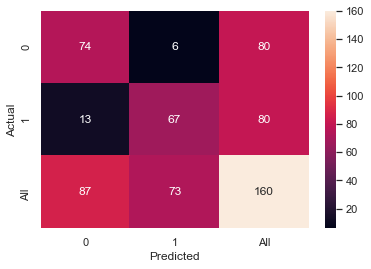

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.4s finished


Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}


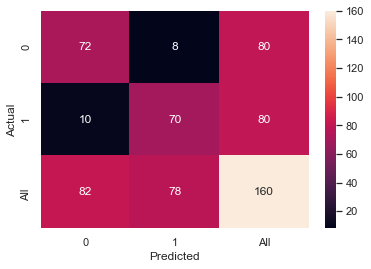

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    8.6s finished


Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}


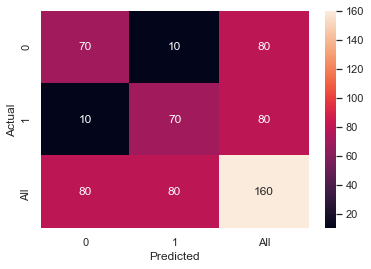

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000


In [21]:
# Naive bayes with hyper parameter tuning
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

mnb_metrics_list = list()
for y_test, X_test, y_train, X_train in zip(y_test_list, X_test_list, y_train_list, X_train_list):
    alpha = np.linspace(start = 0.0, stop = 10.0, num = 30)
    fit_prior = [True, False]

    # Create the random grid
    random_grid = {'alpha': alpha,
                   'fit_prior': fit_prior}
    pprint(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    mnb = MultinomialNB()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 60 different combinations, and use all available cores
    mnb_random = RandomizedSearchCV(estimator = mnb, param_distributions = random_grid, n_iter = 60, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1')

    # Fit the random search model
    mnb_random.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters")
    print(mnb_random.best_params_)

    # The best model
    mnb_best_random = mnb_random.best_estimator_

    # Predict Class
    mnb_random_y_pred = mnb_best_random.predict(X_test)

    # Accuracy 
    mnb_cm, mnb_metrics = getModelInfo(y_test, mnb_random_y_pred)
    mnb_metrics_list.append(mnb_metrics)


Standard configuration 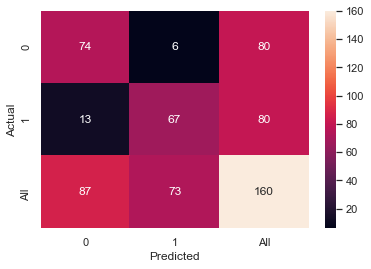
Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
   

Stemming cv=10 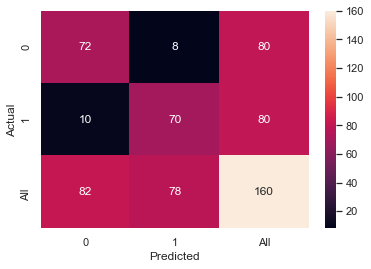
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
   
Lemmatization cv=10 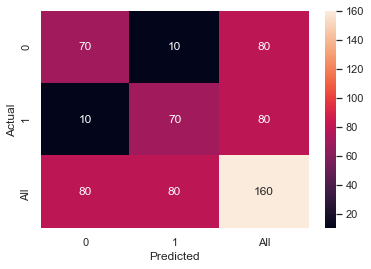
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000

Processing  Word correction  Correction + stemming  Correction + lemmatization
Accuracy           0.881250               0.887500                       0.875
Precision          0.917808               0.897436                       0.875
Recall             0.837500               0.875000                       0.875
F-1                0.875817               0.886076                       0.875


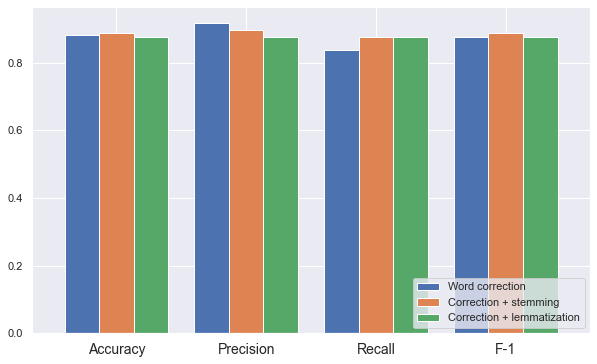

                            Accuracy  Precision  Recall       F-1
Processing                                                       
Word correction              0.88125   0.917808  0.8375  0.875817
Correction + stemming        0.88750   0.897436  0.8750  0.886076
Correction + lemmatization   0.87500   0.875000  0.8750  0.875000


In [25]:
mnb_metrics_list

def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Word correction", "Correction + stemming", "Correction + lemmatization"])
    metrics_df.index.name = "Processing"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
#     flat_list = [item for sublist in metrics_list for item in sublist]
#     for i, v in enumerate(flat_list):
#         ax.text(i-.25, 
#                   v/flat_list[i]+100, 
#                   flat_list[i], 
#                   fontsize=18)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/preprocessing/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Preprocessing', value=["Word correction", "Correction + stemming", "Correction + lemmatization"]*4)
    metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)
    
#save_metrics(mnb_metrics_list)
plotMetricsComparison(mnb_metrics_list, "pre_mnb")

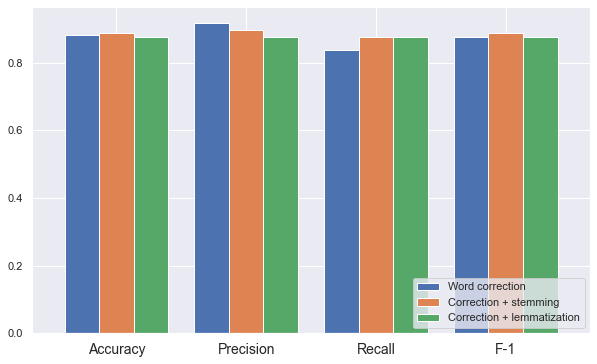

In [27]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(mnb_best_random.coef_))], axis = 1)
coefficients.columns = ['feature', 'coef']
# https://stackoverflow.com/questions/30486263/sorting-by-absolute-value-without-changing-the-data
#print(coefficients.reindex(coefficients.iloc[:,1].abs().sort_values(ascending=False).index)[0:])
#print(coefficients.groupby('coef').count())
# high_neg_mnb = coefficients.reindex(coefficients.iloc[:,1].abs().sort_values(ascending=False).index)['feature'][:801]

# unique, counts = np.unique(mnb_best_random.coef_, return_counts=True)
# dict(zip(unique, counts))

neg_class_prob_sorted = mnb_best_random.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = mnb_best_random.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted)
print(pos_class_prob_sorted)
print(list(np.take(X_train.columns, neg_class_prob_sorted[-10:])))
print(list(np.take(X_train.columns, pos_class_prob_sorted[-10:])))

[   0  983  987 ...  300 1521  866]
[   0  928  931 ...  794 1521  866]
['not', 'stayed', 'would', 'service', 'staff', 'great', 'stay', 'chicago', 'room', 'hotel']
['night', 'stayed', 'would', 'location', 'staff', 'chicago', 'stay', 'great', 'room', 'hotel']
